In [1]:
# 3 August 2021
# Experiment: tried to run featurecounts across all cells in RCMB56-ht (~5k), for each counting read coverage at 1000 
# randomly permuted genomic regions.
# This took an absurd amount of compute, so we only have a few permutations to work with right now.

In [2]:
import pandas as pd
import os
os.chdir('/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/2021-08-02_featurecounts_permutation')
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from statsmodels.stats.multitest import multipletests 

In [4]:
def fit_poisson():
    # Set up dataframe of observed featurecounts
    observed = load_features()
    df = pd.DataFrame(observed)
    df.columns=['Observed']
    
    # Estimate empirical p
    bg = load_backgrounds()
    df['empirical p-val']=observed.index.map(lambda x: ((observed[x] <= bg[x]).sum()+1) / (len(bg[x])+1))
    
    # Fit to Poisson distribution
    mu = bg.mean()
    mu.name = 'mu'
    df = df.join(mu)
    
    # Generate p-values as 1-cdf
    df['poisson_pval'] = df.index.map(lambda x: scipy.stats.poisson.sf(k=df.loc[x,'Observed']-1,mu=df.loc[x,'mu']))
    #df['poisson_qval'] = multipletests(df.poisson_pval)[1]
    return df
fit_poisson()

,Observed,empirical p-val,mu,poisson_pval
barcode,,,,
GTTTCTAGTTGCAATG-1,4,0.255814,2.054688,0.152877
CAGGTTAGTTCCGCAC-1,4,0.643411,6.796875,0.907012
AATCATCCATTAAACC-1,2,0.736434,4.062500,0.912895
AAGGATCCAAATATCC-1,2,0.248062,0.601562,0.122416
GAGCCACTCAGGTTTA-1,12,0.325581,9.687500,0.268294
...,...,...,...,...
CGGACCTAGACAGGCG-1,56,0.224806,36.804688,0.001928
AGGCGGATCACGTTAA-1,42,0.147287,25.648438,0.001864
GATTCGCCATTCAGCA-1,12,0.224806,7.562500,0.082952


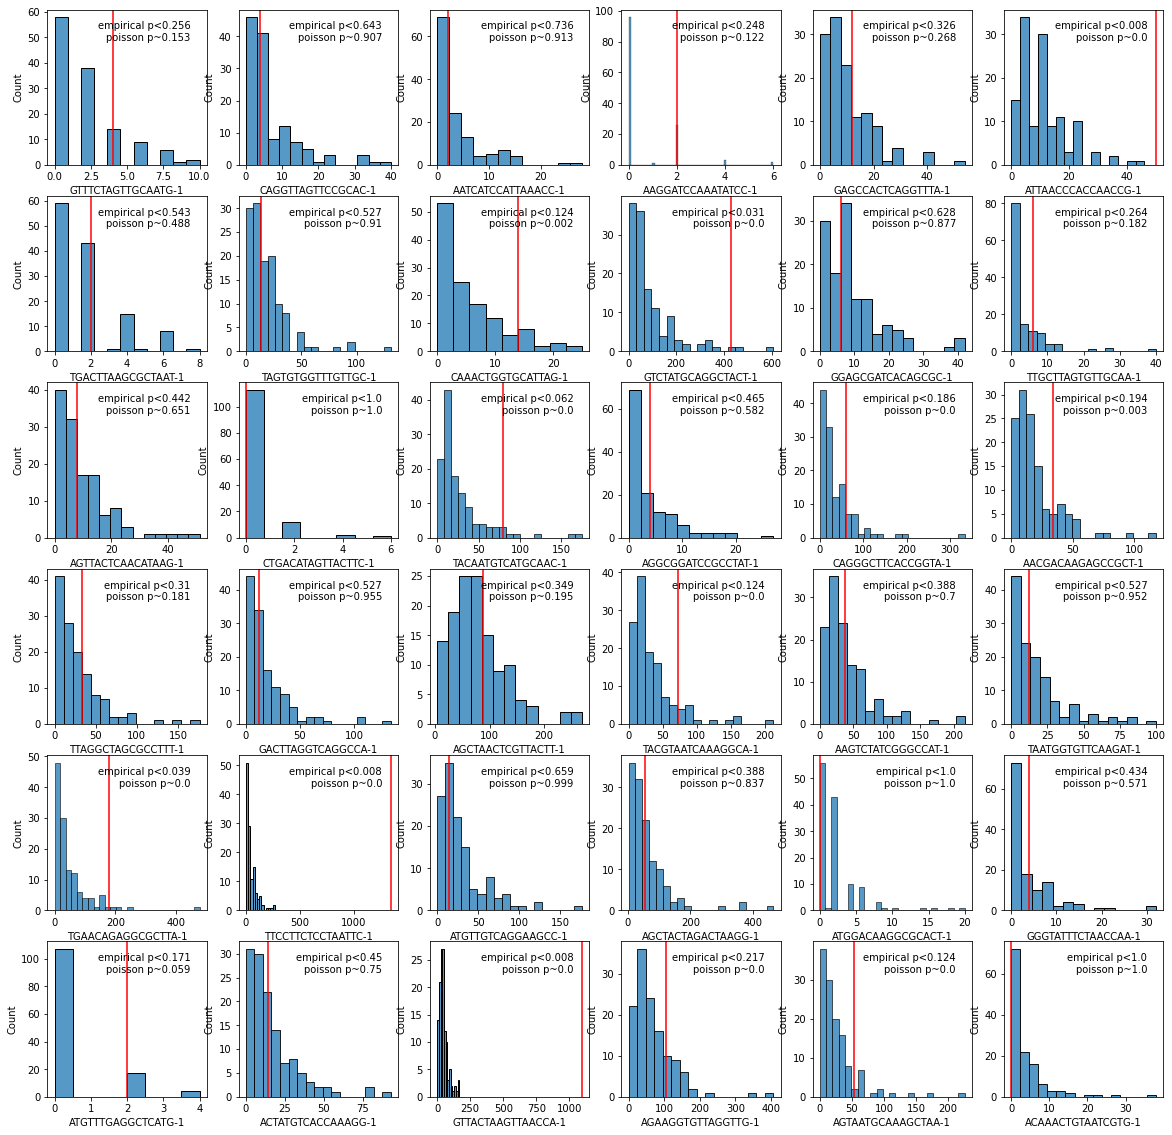

In [5]:
def load_features():
    '''
    returns: series
    index: barcode
    '''
    f = 'RCMB56-ht.tsv'
    df = pd.read_csv(f,sep='\t',index_col='barcode')
    df = df.ecDNA1
    return df
def load_backgrounds():
    '''
    returns: dataframe
    rows: random permutation
    columns: barcode.bam
    access as df[barcode.bam]
    '''
    f = 'out.tsv'
    df = pd.read_csv(f,sep='\t',index_col='Status')
    df.columns = df.columns.map(lambda x: x.split('.')[0])
    return df
def histogram():
    w=6
    h=6
    backgrounds = load_backgrounds()
    poisson = fit_poisson()
    poisson = poisson.loc[backgrounds.columns]
    backgrounds=backgrounds.iloc[:,:w*h]
    fig,axes = plt.subplots(h,w, figsize=(20,20))
    for i in range(h*w):
        sns.histplot(ax=axes[i//h,i%h],data=backgrounds.iloc[:,i])
        axes[i//h,i%h].axvline(poisson.iloc[i,0],c='red')
        text = 'empirical p<'+str(round(poisson.iloc[i,1],3))+'\npoisson p~'+str(round(poisson.iloc[i,3],3))
        axes[i//h,i%h].text(0.9,0.8,text,horizontalalignment='right',transform=axes[i//h,i%h].transAxes)
    fig.savefig('single cell ecDNA detection.svg')
    fig.savefig('single cell ecDNA detection.png')
histogram()

In [121]:
observed=load_features()
o = observed['CTGACATAGTTACTTC-1']
bg=load_backgrounds()
b = bg['CTGACATAGTTACTTC-1']
(o <= b).sum()

128

In [120]:
b

Status
RCMB56_ecDNA_1.hg38.1      0
RCMB56_ecDNA_1.hg38.10     0
RCMB56_ecDNA_1.hg38.100    2
RCMB56_ecDNA_1.hg38.101    0
RCMB56_ecDNA_1.hg38.102    0
                          ..
RCMB56_ecDNA_1.hg38.95     0
RCMB56_ecDNA_1.hg38.96     0
RCMB56_ecDNA_1.hg38.97     0
RCMB56_ecDNA_1.hg38.98     0
RCMB56_ecDNA_1.hg38.99     0
Name: CTGACATAGTTACTTC-1, Length: 128, dtype: int64